In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATASET_DIR = "DatasetHAR"
ACTIVITIES = [0, 1, 2, 3, 4, 5]  # 0: Rest, 1: Fold clothes, 2: Sweep, 3: Walk, 4: Move boxes, 5: Bike

LABEL_MAP = {
    0: "Rest",
    1: "Fold clothes",
    2: "Sweep",
    3: "Walk",
    4: "Move boxes",
    5: "Bike (stationary)",
}

In [2]:
def fetch_and_transform_data():
    all_subjects_data = []

    for subject_folder in sorted(os.listdir(DATASET_DIR)):
        subject_path = os.path.join(DATASET_DIR, subject_folder)
        
        if not os.path.isdir(subject_path):
            continue
        
        imu_file = os.path.join(subject_path, f"IMU{subject_folder}.csv")
        biomarkers_file = os.path.join(subject_path, f"Biomarkers{subject_folder}.csv")
        
        if not (os.path.exists(imu_file) and os.path.exists(biomarkers_file)):
            continue
        
        try:
            df_imu = pd.read_csv(imu_file)
            df_biomarkers = pd.read_csv(biomarkers_file)
            
            if len(df_biomarkers) > 0 and 'ActivityLabel' in df_biomarkers.columns:
                labels = df_biomarkers['ActivityLabel'].values
                labels_upsampled = np.repeat(labels, len(df_imu) // len(df_biomarkers) + 1)
                labels_upsampled = labels_upsampled[:len(df_imu)]
                df_imu['label'] = labels_upsampled
            else:
                continue
            
        except Exception as e:
            print(f"Error loading {subject_folder}: {e}")
            continue
        
        df_processed = apply_global_frame(df_imu)
        
        all_subjects_data.append({
            'subject_id': subject_folder,
            'data': df_processed
        })
        
        print(f"Processed: {subject_folder} ({len(df_processed)} samples)")

    print(f"\nTotal subjects processed: {len(all_subjects_data)}")
    return all_subjects_data

In [3]:
def apply_global_frame(df):
    quat = df[[
        "q_x_chest",
        "q_y_chest",
        "q_z_chest",
        "q_w_chest"
    ]].to_numpy()

    quat /= (np.linalg.norm(quat, axis=1, keepdims=True) + 1e-9)
    rot = R.from_quat(quat)

    acc_local = df[[
        "a_x_chest",
        "a_y_chest",
        "a_z_chest"
    ]].to_numpy()

    acc_enu = rot.apply(acc_local)
    acc_enu[:, 2] -= 9.81

    gyro_local = df[[
        "g_x_chest",
        "g_y_chest",
        "g_z_chest"
    ]].to_numpy()

    gyro_enu = rot.apply(gyro_local)

    df_out = pd.DataFrame({
        'ax': acc_local[:, 0],
        'ay': acc_local[:, 1],
        'az': acc_local[:, 2],
        'gx': gyro_local[:, 0],
        'gy': gyro_local[:, 1],
        'gz': gyro_local[:, 2],
        'ax_enu': acc_enu[:, 0],
        'ay_enu': acc_enu[:, 1],
        'az_enu': acc_enu[:, 2],
        'gx_enu': gyro_enu[:, 0],
        'gy_enu': gyro_enu[:, 1],
        'gz_enu': gyro_enu[:, 2],
        'label': df['label'].values
    })

    return df_out

In [4]:
def visualize_gft_data(all_subjects_data, max_plots):
    plot_count = 0

    for subject_info in all_subjects_data:
        if plot_count >= max_plots:
            break
        
        df = subject_info['data']
        subject_id = subject_info['subject_id']
        
        for activity in ACTIVITIES:
            if plot_count >= max_plots:
                break
                
            df_act = df[df['label'] == activity].reset_index(drop=True)
            if len(df_act) == 0:
                continue

            title = (
                f"Activity: {LABEL_MAP.get(activity, f'Activity {activity}')} (label={activity}), "
                f"Subject: {subject_id}"
            )

            time = np.arange(len(df_act))

            accel_mag = np.sqrt(
                df_act["ax_enu"]**2 +
                df_act["ay_enu"]**2 +
                df_act["az_enu"]**2
            )

            plt.figure(figsize=(15, 4))
            plt.title(f"{title} - Accelerometer (ENU Frame)")
            plt.plot(time, df_act["ax_enu"], label="Accel X_ENU")
            plt.plot(time, df_act["ay_enu"], label="Accel Y_ENU")
            plt.plot(time, df_act["az_enu"], label="Accel Z_ENU")
            plt.plot(time, accel_mag, label="Accel Magnitude", linewidth=2)
            plt.xlabel("Sample")
            plt.ylabel("Acceleration (m/s²)")
            plt.ylim(-50, 50)
            plt.legend(loc="upper right")
            plt.grid(True)
            plt.show()

            gyro_mag = np.sqrt(
                df_act["gx_enu"]**2 +
                df_act["gy_enu"]**2 +
                df_act["gz_enu"]**2
            )

            plt.figure(figsize=(15, 4))
            plt.title(f"{title} - Gyroscope (ENU Frame)")
            plt.plot(time, df_act["gx_enu"], "--", label="Gyro X_ENU")
            plt.plot(time, df_act["gy_enu"], "--", label="Gyro Y_ENU")
            plt.plot(time, df_act["gz_enu"], "--", label="Gyro Z_ENU")
            plt.plot(time, gyro_mag, label="Gyro Magnitude", linewidth=2)
            plt.xlabel("Sample")
            plt.ylabel("Angular Velocity")
            plt.ylim(-400, 400)
            plt.legend(loc="upper right")
            plt.grid(True)
            plt.show()

            plot_count += 1


In [5]:
def save_gft_data(all_subjects_data, output_dir="DatasetGFT"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    for subject_info in all_subjects_data:
        subject_id = subject_info['subject_id']
        df = subject_info['data']
        
        subject_folder = os.path.join(output_dir, subject_id)
        if not os.path.exists(subject_folder):
            os.makedirs(subject_folder)
        
        output_file = os.path.join(subject_folder, f"IMU_GFT_{subject_id}.csv")
        df.to_csv(output_file, index=False)
        print(f"Saved: {output_file} ({len(df)} samples)")
    
    print(f"\nTotal subjects saved: {len(all_subjects_data)}")
    print(f"Data saved to: {output_dir}")

Processed: Subject01 (110740 samples)
Processed: Subject02 (110563 samples)
Processed: Subject03 (98902 samples)
Processed: Subject04 (106672 samples)
Processed: Subject05 (105411 samples)
Processed: Subject06 (103438 samples)
Processed: Subject07 (108957 samples)
Processed: Subject08 (105612 samples)
Processed: Subject09 (102335 samples)
Processed: Subject10 (110796 samples)
Processed: Subject11 (107280 samples)
Processed: Subject12 (102526 samples)
Processed: Subject13 (103206 samples)
Processed: Subject14 (115858 samples)
Processed: Subject15 (104783 samples)
Processed: Subject16 (104821 samples)
Processed: Subject17 (108276 samples)
Processed: Subject18 (109061 samples)
Processed: Subject19 (106042 samples)
Processed: Subject21 (99207 samples)
Processed: Subject22 (103972 samples)
Processed: Subject23 (110256 samples)
Processed: Subject24 (106755 samples)
Processed: Subject25 (104556 samples)
Processed: Subject26 (107524 samples)
Processed: Subject27 (103814 samples)
Processed: Sub

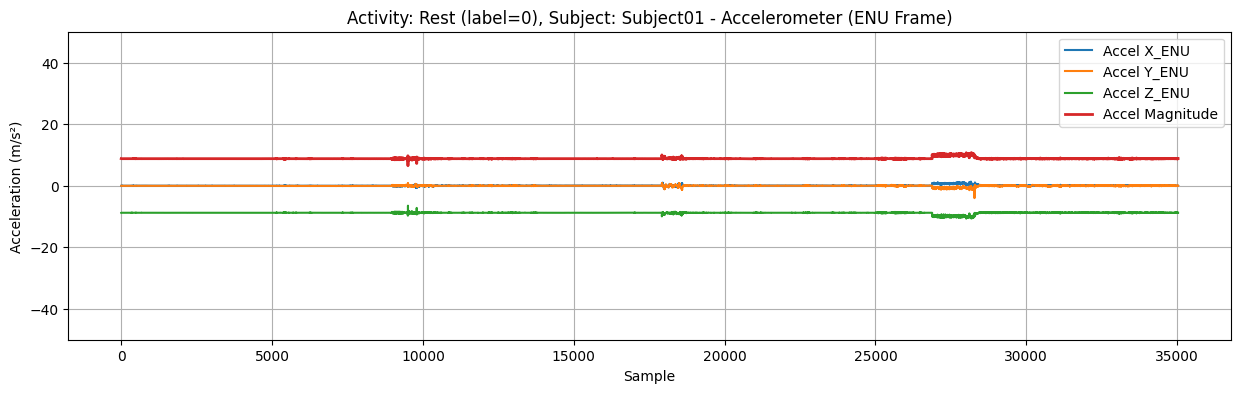

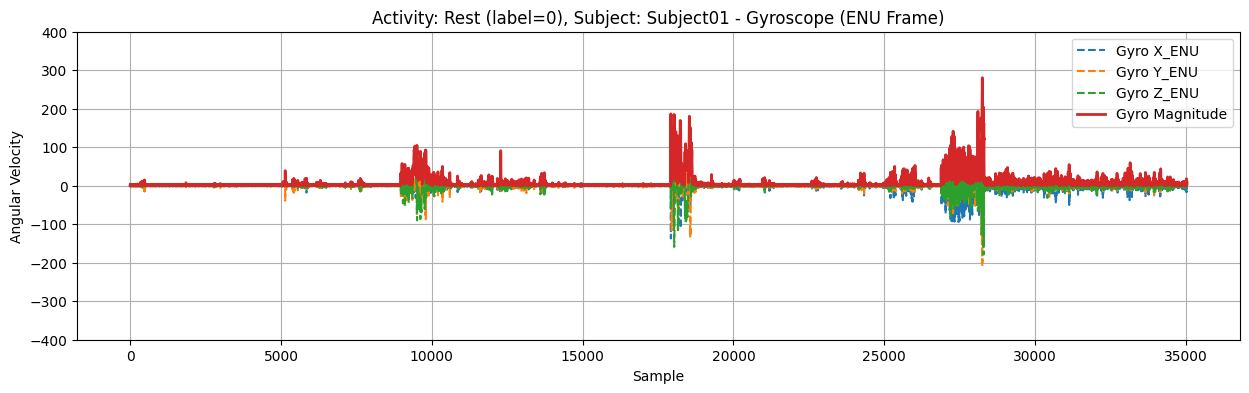

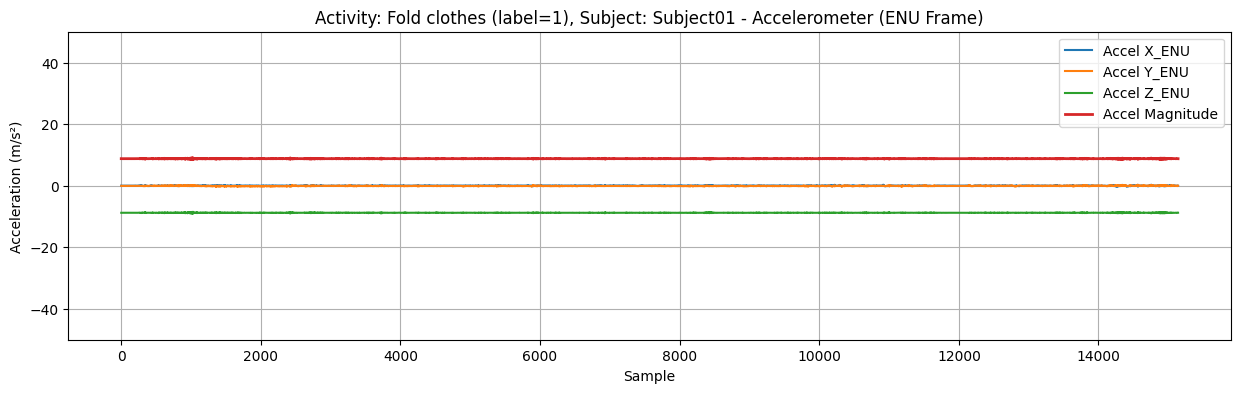

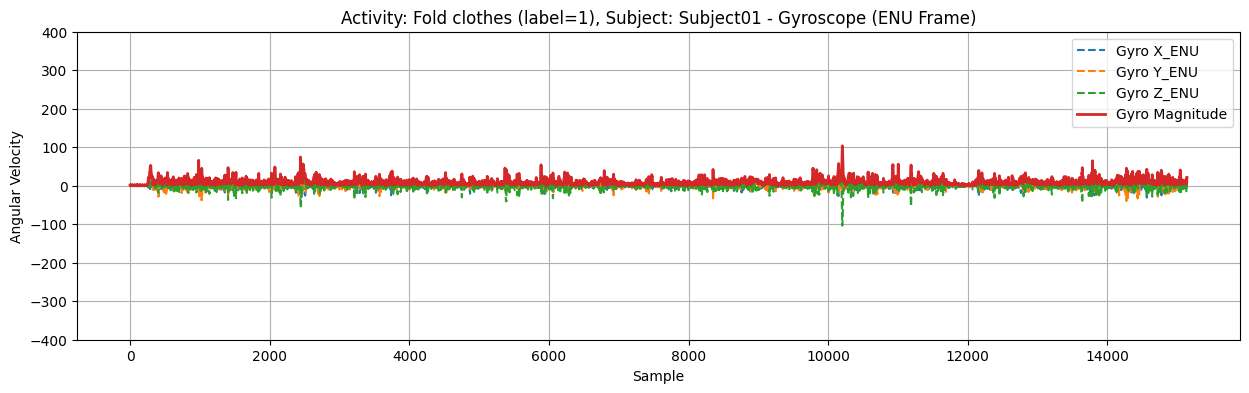

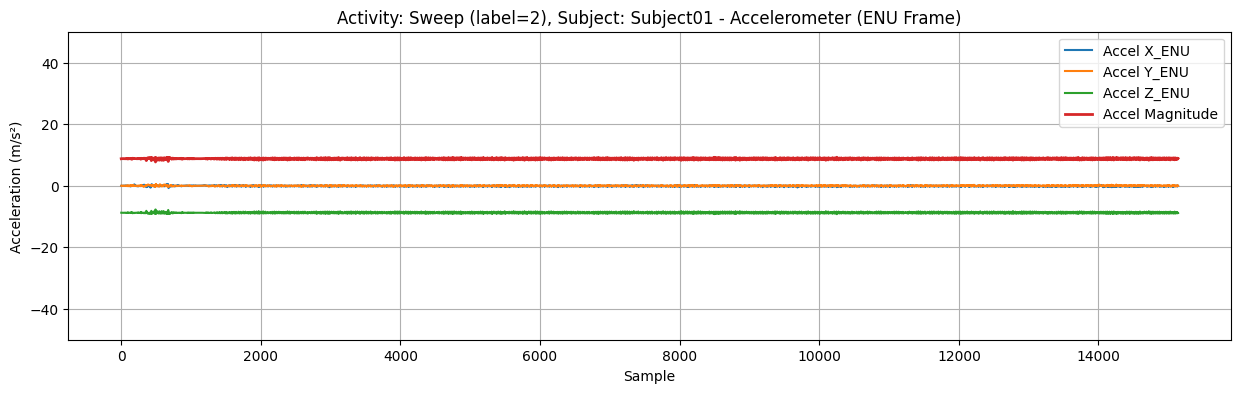

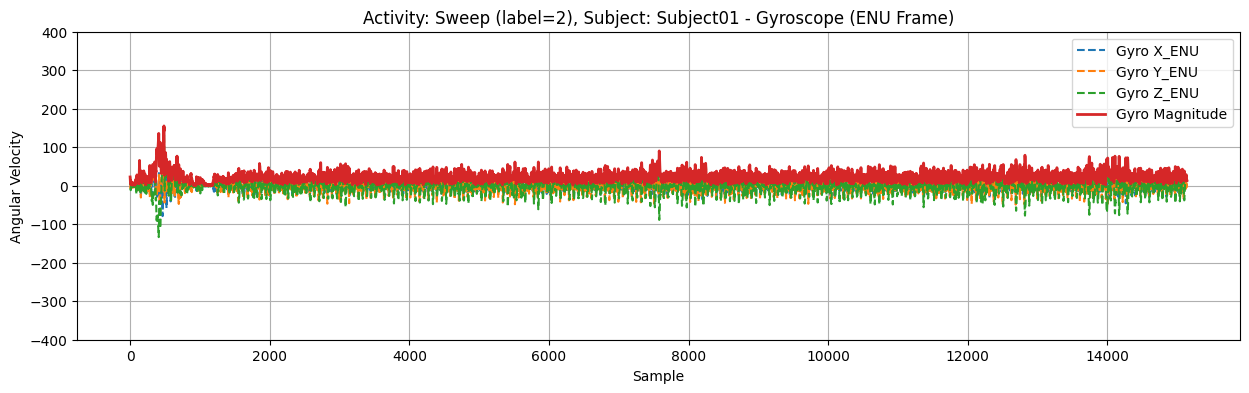

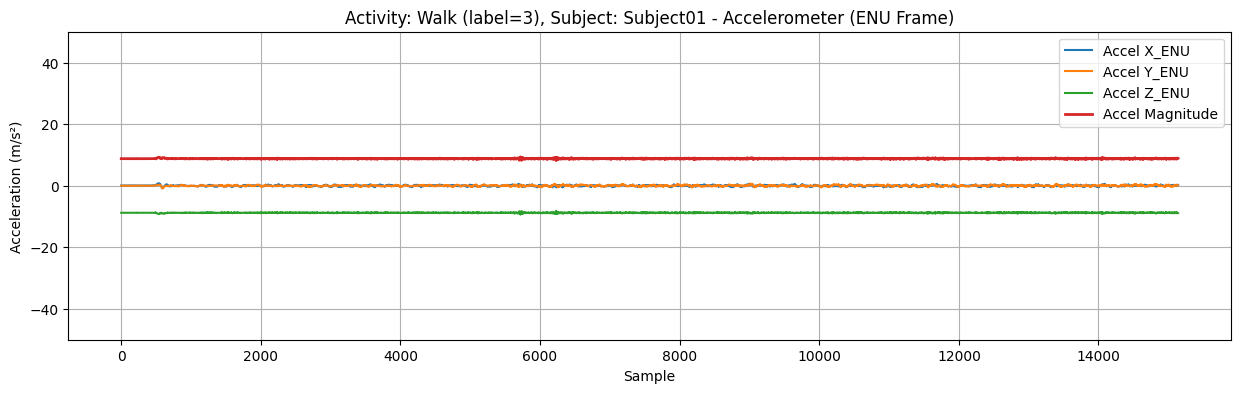

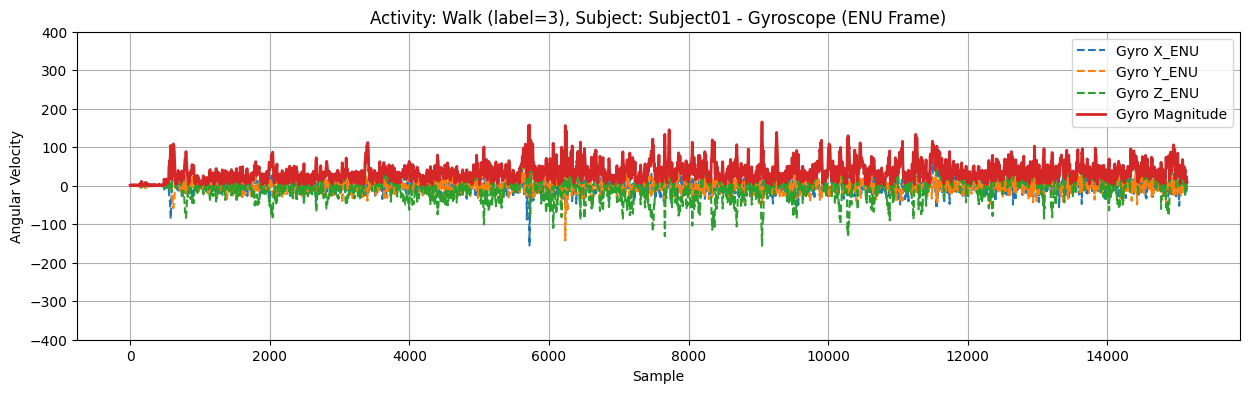

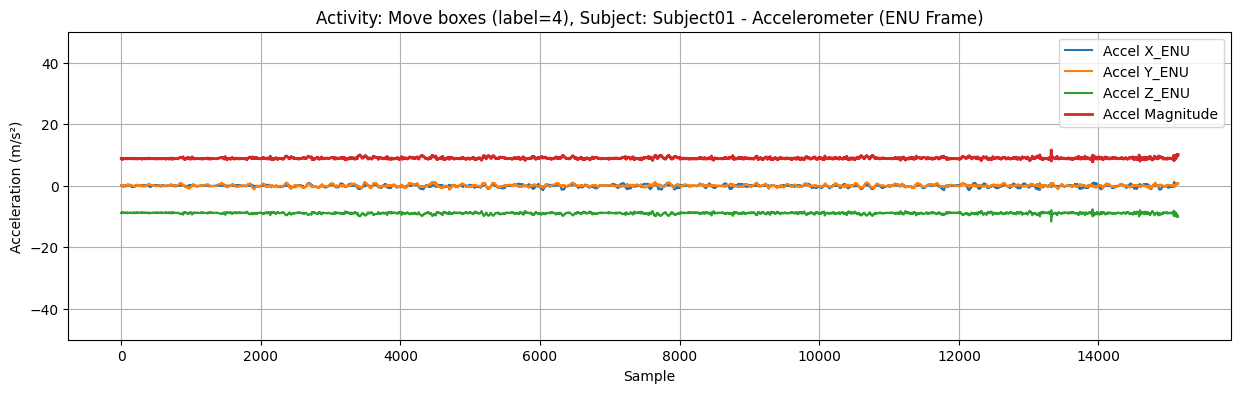

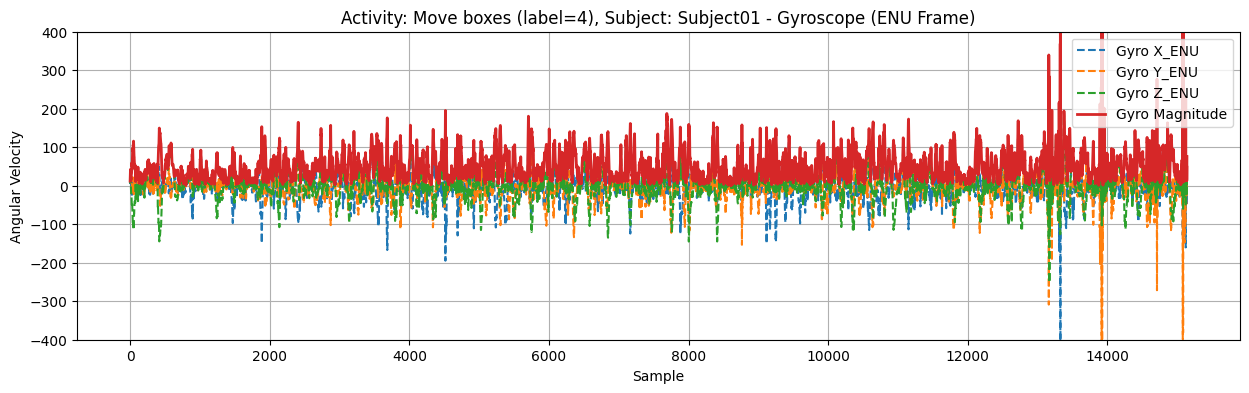

Created output directory: DatasetGFT
Saved: DatasetGFT\Subject01\IMU_GFT_Subject01.csv (110740 samples)
Saved: DatasetGFT\Subject02\IMU_GFT_Subject02.csv (110563 samples)
Saved: DatasetGFT\Subject03\IMU_GFT_Subject03.csv (98902 samples)
Saved: DatasetGFT\Subject04\IMU_GFT_Subject04.csv (106672 samples)
Saved: DatasetGFT\Subject05\IMU_GFT_Subject05.csv (105411 samples)
Saved: DatasetGFT\Subject06\IMU_GFT_Subject06.csv (103438 samples)
Saved: DatasetGFT\Subject07\IMU_GFT_Subject07.csv (108957 samples)
Saved: DatasetGFT\Subject08\IMU_GFT_Subject08.csv (105612 samples)
Saved: DatasetGFT\Subject09\IMU_GFT_Subject09.csv (102335 samples)
Saved: DatasetGFT\Subject10\IMU_GFT_Subject10.csv (110796 samples)
Saved: DatasetGFT\Subject11\IMU_GFT_Subject11.csv (107280 samples)
Saved: DatasetGFT\Subject12\IMU_GFT_Subject12.csv (102526 samples)
Saved: DatasetGFT\Subject13\IMU_GFT_Subject13.csv (103206 samples)
Saved: DatasetGFT\Subject14\IMU_GFT_Subject14.csv (115858 samples)
Saved: DatasetGFT\Subject1

In [6]:
if __name__ == "__main__":
    subjects_data = fetch_and_transform_data()
    visualize_gft_data(subjects_data, max_plots=5)
    save_gft_data(subjects_data, output_dir="DatasetGFT")